# Laboratorium

### Konfiguracja

In [150]:
from typing import List
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from matplotlib.widgets import Button
import random
import heapq
import functools
import json as js
from panda3d.core import Triangulator
import math
FIG_EPS = 0.1

def dist(point1, point2):
    return np.sqrt(np.power(point1[0] - point2[0], 2) + np.power(point1[1] - point2[1], 2))

class _Button_callback(object):
    def __init__(self, scenes):
        self.i = 0
        self.scenes = scenes
        self.adding_points = False
        self.added_points = []
        self.adding_lines = False
        self.added_lines = []
        self.adding_rects = False
        self.added_rects = []

    def set_axes(self, ax):
        self.ax = ax
        
    def next(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        self.draw(autoscaling = True)

    def prev(self, event):
        self.i = (self.i - 1) % len(self.scenes)
        self.draw(autoscaling = True)
        
    def add_point(self, event):
        self.adding_points = not self.adding_points
        self.new_line_point = None
        if self.adding_points:
            self.adding_lines = False
            self.adding_rects = False
            self.added_points.append(PointsCollection([]))
         
    def add_line(self, event):   
        self.adding_lines = not self.adding_lines
        self.new_line_point = None
        if self.adding_lines:
            self.adding_points = False
            self.adding_rects = False
            self.added_lines.append(LinesCollection([]))

    def add_rect(self, event):
        self.adding_rects = not self.adding_rects
        self.new_line_point = None
        if self.adding_rects:
            self.adding_points = False
            self.adding_lines = False
            self.new_rect()
    
    def new_rect(self):
        self.added_rects.append(LinesCollection([]))
        self.rect_points = []
    
    def on_click(self, event):
        if event.inaxes != self.ax:
            return
        new_point = (event.xdata, event.ydata)
        if self.adding_points:
            self.added_points[-1].add_points([new_point])
            self.draw(autoscaling = False)
        elif self.adding_lines:
            if self.new_line_point is not None:
                self.added_lines[-1].add([self.new_line_point, new_point])
                self.new_line_point = None
                self.draw(autoscaling = False)
            else:
                self.new_line_point = new_point
        elif self.adding_rects:
            if len(self.rect_points) == 0:
                self.rect_points.append(new_point)
            elif len(self.rect_points) == 1:
                self.added_rects[-1].add([self.rect_points[-1], new_point])
                self.rect_points.append(new_point)
                self.draw(autoscaling = False)
            elif len(self.rect_points) > 1:
                if dist(self.rect_points[0], new_point) < FIG_EPS:
                    self.added_rects[-1].add([self.rect_points[-1], self.rect_points[0]])
                    self.new_rect()
                else:    
                    self.added_rects[-1].add([self.rect_points[-1], new_point])
                    self.rect_points.append(new_point)
                self.draw(autoscaling = False)
        
    def draw(self, autoscaling = True):
        if not autoscaling:
            xlim = self.ax.get_xlim()
            ylim = self.ax.get_ylim()
        self.ax.clear()
        for collection in (self.scenes[self.i].points + self.added_points):
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), **collection.kwargs)
        for collection in (self.scenes[self.i].lines + self.added_lines + self.added_rects):
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale(autoscaling)
        if not autoscaling:
            self.ax.set_xlim(xlim)
            self.ax.set_ylim(ylim)
        plt.draw()

### Interfejsy

[Dostępne kolory](https://matplotlib.org/3.1.1/gallery/color/named_colors.html)

[Dostępne znaczniki punktów](https://matplotlib.org/3.1.1/api/markers_api.html#module-matplotlib.markers)

In [151]:
class Scene:
    def __init__(self, points=[], lines=[]):
        self.points=points
        self.lines=lines

class PointsCollection:
    def __init__(self, points, **kwargs):
        self.points = points
        self.kwargs = kwargs
    
    def add_points(self, points):
        self.points = self.points + points

class LinesCollection:
    def __init__(self, lines, **kwargs):
        self.lines = lines
        self.kwargs = kwargs
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        return mcoll.LineCollection(self.lines, **self.kwargs)
    
class Plot:
    def __init__(self, scenes = [Scene()], json = None):
        if json is None:
            self.scenes = scenes
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]], 
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]]) 
                           for scene in js.loads(json)]
        
    def __configure_buttons(self):
        plt.subplots_adjust(bottom=0.2)
        ax_prev = plt.axes([0.6, 0.05, 0.15, 0.075])
        ax_next = plt.axes([0.76, 0.05, 0.15, 0.075])
        ax_add_point = plt.axes([0.44, 0.05, 0.15, 0.075])
        ax_add_line = plt.axes([0.28, 0.05, 0.15, 0.075])
        ax_add_rect = plt.axes([0.12, 0.05, 0.15, 0.075])
        b_next = Button(ax_next, 'Następny')
        b_next.on_clicked(self.callback.next)
        b_prev = Button(ax_prev, 'Poprzedni')
        b_prev.on_clicked(self.callback.prev)
        b_add_point = Button(ax_add_point, 'Dodaj punkt')
        b_add_point.on_clicked(self.callback.add_point)
        b_add_line = Button(ax_add_line, 'Dodaj linię')
        b_add_line.on_clicked(self.callback.add_line)
        b_add_rect = Button(ax_add_rect, 'Dodaj figurę')
        b_add_rect.on_clicked(self.callback.add_rect)
        return [b_prev, b_next, b_add_point, b_add_line, b_add_rect]
    
    def add_scene(self, scene):
        self.scenes.append(scene)
    
    def add_scenes(self, scenes):
        self.scenes = self.scenes + scenes

    def toJson(self):
        return js.dumps([{"points": [np.array(pointCol.points).tolist() for pointCol in scene.points], 
                          "lines":[linesCol.lines for linesCol in scene.lines]} 
                         for scene in self.scenes])    
     
    def get_added_points(self):
        if self.callback:
            return self.callback.added_points
        else:
            return None
  
    def get_added_lines(self):
        if self.callback:
            return self.callback.added_lines
        else:
            return None
        
    def get_added_figure(self):
        if self.callback:
            return self.callback.added_rects
        else:
            return None
    
    def get_added_elements(self):
        if self.callback:
            return Scene(self.callback.added_points, self.callback.added_lines+self.callback.added_rects)
        else:
            return None
    
    def draw(self):
        plt.close()
        fig = plt.figure()
        self.callback = _Button_callback(self.scenes)
        self.widgets = self.__configure_buttons()
        ax = plt.axes(autoscale_on = False)
        self.callback.set_axes(ax)
        fig.canvas.mpl_connect('button_press_event', self.callback.on_click)
        plt.show()
        self.callback.draw()

<IPython.core.display.Javascript object>


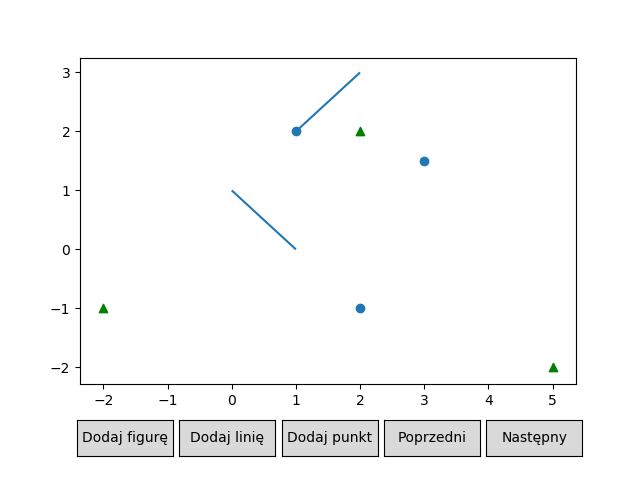

In [152]:
%matplotlib notebook

scenes=[Scene([PointsCollection([(1, 2), (3, 1.5), (2, -1)]), 
               PointsCollection([(5, -2), (2, 2), (-2, -1)], color='green', marker = "^")], 
              [LinesCollection([[(1,2),(2,3)], [(0,1),(1,0)]])]), 
        Scene([PointsCollection([(1, 2), (3, 1.5), (2, -1)], color='red'), 
               PointsCollection([(5, -2), (2, 2), (-2, 1)], color='black')], 
              [LinesCollection([[(-1,2),(-2,3)], [(0,-1),(-1,0)]])])]

plot = Plot(scenes)
plot.draw()


In [ ]:
%matplotlib notebook
plot2=Plot()
plot2.draw()

In [ ]:
def prepare_points(plot):
    a=plot.get_added_figure()
    lines_to_sort=[]
    res=[]
    for i in range(len(a)):
        t=a[i].lines
        for line in t:
            x=((line, i//2))
            lines_to_sort.append(x)
    
    lines_to_sort=sorted(lines_to_sort, key = lambda a: min(a[0][0][0], a[0][1][0]) )
  
    for i in range(1, len(lines_to_sort)):
        x=lines_to_sort[i]
        y=lines_to_sort[i-1]
        if(x[1]!=y[1]):
            p_x=x[0]
            p_y=y[0]
            if (dist(p_x[0], p_y[0]) < 10*TOLERANCE and dist(p_x[1], p_y[1])<10*TOLERANCE) or (dist(p_x[1], p_y[0])<10*TOLERANCE and dist(p_x[0], p_y[1])<10*TOLERANCE):
                y=(x[0], y[1])
        res.append(y)  
    res.append(lines_to_sort[len(lines_to_sort)-1])
    res=sorted(res, key = lambda r: r[1])  
    return res  

In [153]:
class Point:
    def __init__(self,x,y):
        self.x=x
        self.y=y
        self.adjacent={}
    def add_adjacent(self,point):
        self.adjacent[(point[0],point[1])]=point[2]
    def __str__(self):
        return "as point "+ "("+str(self.x)+", "+str(self.y)+")"

In [154]:
def det(p, q, r):
    return ((q[0] - p[0])*(r[1] - p[1]) - (r[0] - p[0])*(q[1] - p[1]))
det((0,0),(1,0),(1,-1))

-1

In [197]:
def angle(p1,p2,p3):
    from math import sqrt,acos
    v1=[p1[0]-p2[0],p1[1]-p2[1]]
    v2=[p3[0]-p2[0],p3[1]-p2[1]]
    return acos(((v1[0]*v2[0])+(v1[1]*v2[1]))/(sqrt(v1[0]**2+v1[1]**2)*sqrt(v2[0]**2+v2[1]**2)))
def sign(a):
    if a==0:
        return 0
    if a<0:
        return -1
    return 1
print(sign(-1))

-1


In [252]:
class Polygon:
    def __init__(self):
        self.points={}
        self.faces={}
    def add_edge(self,start,edge):
        if self.points.get(start) is None:
            self.points[start]=Point(start[0],start[1])
        self.points[start].add_adjacent(edge)
    def add_edge_to_face(self,edge):
        if self.faces.get(edge[2]) is None:
            self.faces[edge[2]]={}
        self.faces[edge[2]][(edge[0],edge[1])]=(edge[0],edge[1])
    def parse_to_adjacency_list(self,edges):
        for edge in edges:
            a=(edge[0][0],edge[0][1])
            e=(edge[1][0],edge[1][1],edge[2])
            self.add_edge(a,e)
            self.add_edge_to_face(e)
    def triangulate_face(self,face):
        arr=[]
        for vert in face:
            arr.append((vert[0],vert[1]))
        from panda3d.core import Triangulator
        tri=Triangulator()
        for i in range(len(arr)):
            tri.addPolygonVertex(i)
        for p in arr:
            tri.addVertex(p)
        tri.triangulate()
        for i in range(tri.getNumTriangles()):
            face_num=len(self.faces)+1
            self.add_edge_to_face((arr[tri.getTriangleV0(i)][0],arr[tri.getTriangleV0(i)][1],face_num))
            self.add_edge_to_face((arr[tri.getTriangleV1(i)][0],arr[tri.getTriangleV1(i)][1],face_num))
            self.add_edge_to_face((arr[tri.getTriangleV2(i)][0],arr[tri.getTriangleV2(i)][1],face_num))
    def triangulate_faces(self):
        n=len(self.faces)+1
        for i in range(1,n):
            face=self.faces.get(i)
            self.triangulate_face(face)
#         for i in range(1,n):
#             self.faces.pop(i)
    def find_outer_triangle():
        max_x=-1000000
        min_x=1000000
        max_y=-1000000
        min_y=1000000
        for v in list(self.points.keys()):
            max_x=max(v[0],max_x)
            min_x=min(v[0],min_x)
            max_y=max(v[1],max_y)
            min_y=min(v[1],min_y)
        x_w=abs(max_x-min_x)
        y_w=abs(max_y-min_y)
    def convex_hull(self):
        arr=list(self.points.keys())
        for i in range(len(arr)):
            arr[i]=[arr[i][0],arr[i][1]]
        from scipy.spatial import ConvexHull
        hull=ConvexHull(arr)
        hull_vertices=np.append(hull.vertices,[hull.vertices[0],hull.vertices[1]])
        in_hull={}
        for i in hull_vertices:
            in_hull[(arr[i][0],arr[i][1])]=1
        for i in range(1,len(hull_vertices)-1):
            act_v=(arr[hull_vertices[i]][0],arr[hull_vertices[i]][1])
            prev_v=(arr[hull_vertices[i-1]][0],arr[hull_vertices[i-1]][1])
            act_on_hull=act_v=(arr[hull_vertices[i]][0],arr[hull_vertices[i]][1])
            next_on_hull=(arr[hull_vertices[i+1]][0],arr[hull_vertices[i+1]][1])
            act_package=[act_v]
            print(act_on_hull,next_on_hull)
            while act_v!=next_on_hull:
                print('act_v',act_v,next_on_hull,act_package)
                if det(act_on_hull,next_on_hull,act_v)==0 and act_v!=act_on_hull:
#                    
                    print('na otoczce',act_package)
                act_v_adj=list(self.points.get(act_v).adjacent.keys())
                next_v=act_v_adj[0]
                for v in act_v_adj:
#                     print(prev_v,act_v,next_v,v,(det(prev_v,act_v,next_v)),(det(prev_v,act_v,v)))
                    if sign(det(prev_v,act_v,next_v)) ==sign(det(prev_v,act_v,v)):
#                         print('po tej samej stronie')
                        if angle(prev_v,act_v,next_v)<angle(prev_v,act_v,v):
                            next_v=v
                    else:
#                         print('po roznych stronach')
                        if sign(det(prev_v,act_v,next_v))>sign(det(prev_v,act_v,v)):
                            next_v=v
                    
#                 print(next_v)
                prev_v=act_v
                act_v=next_v
                act_package.append(act_v)
#             print(act_package)

In [253]:
def read_polygons_from_file(filename):
    with open(filename) as f:
        data = js.load(f)
    tmp=Polygon()
    tmp.parse_to_adjacency_list(data[0]['edges'])
    return tmp

In [257]:
poly=read_polygons_from_file("/home/piotr/Dokumenty/test3.json")
poly.triangulate_faces()
# for v in poly.faces:
#     print(v,poly.faces.get(v).keys())
poly.convex_hull()
# for v in poly.faces:
#     print(v,poly.faces.get(v).keys())


(1, 0) (1, 1)
act_v (1, 0) (1, 1) [(1, 0)]
(1, 1) (0, 1)
act_v (1, 1) (0, 1) [(1, 1)]
(0, 1) (0, 0)
act_v (0, 1) (0, 0) [(0, 1)]
(0, 0) (1, 0)
act_v (0, 0) (1, 0) [(0, 0)]


In [ ]:
from panda3d.core import Triangulator
tri=Triangulator()
for i in range(13):
    tri.addPolygonVertex(i)

arr=[(1,3),(2,1),(6,1),(8,2),(9,4),(7,6),(6,6),(7,4),(6,2),(4,6),(3,6),(2,2),(2,6)]
print(len(arr))
for p in arr:
    tri.addVertex(p)
tri.triangulate()
print(tri.getNumTriangles())
print(tri.getNumVertices())
for i in range(tri.getNumTriangles()):
    print(arr[tri.getTriangleV0(i)],arr[tri.getTriangleV1(i)],arr[tri.getTriangleV2(i)])